Installing dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

Creating Path

In [2]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset\example_submission.csv
./dataset\fer2013.tar.gz
./dataset\icml_face_data.csv
./dataset\test.csv
./dataset\train.csv


Loading the dataset

In [3]:
data = pd.read_csv('./dataset/icml_face_data.csv')

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Plot data

In [5]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels and pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label
  
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

callback

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

more about dataset

In [7]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

create label dictionary

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

training, testing, and validation

In [9]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

examples

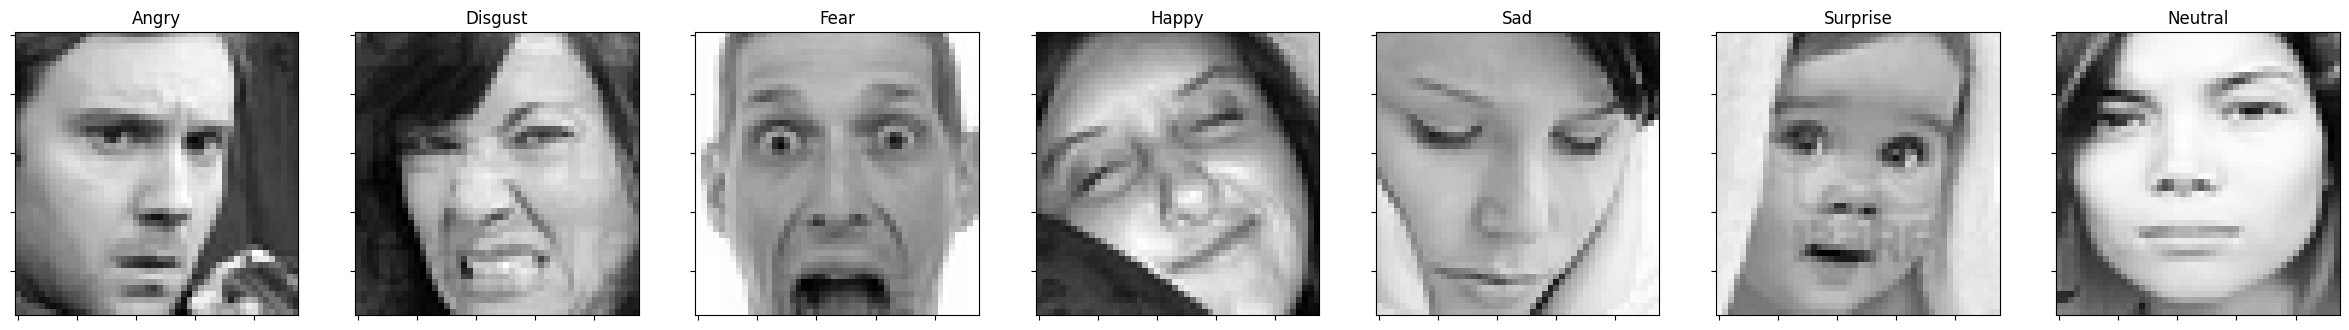

In [12]:
plot_all_emotions()

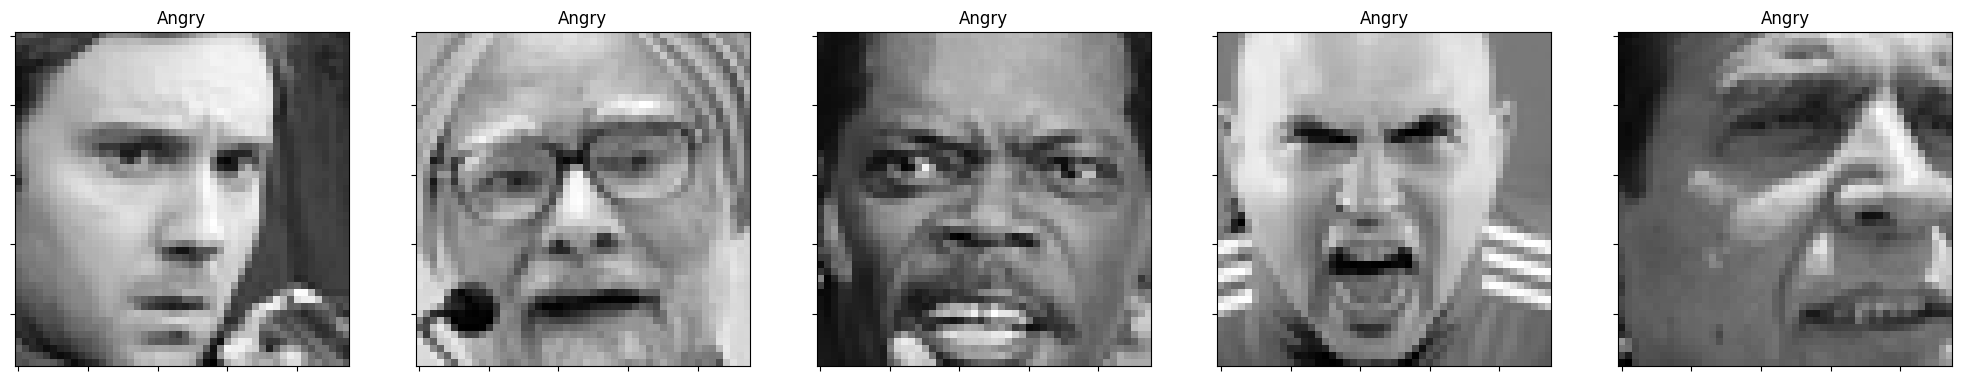

In [13]:
plot_examples(label=0)

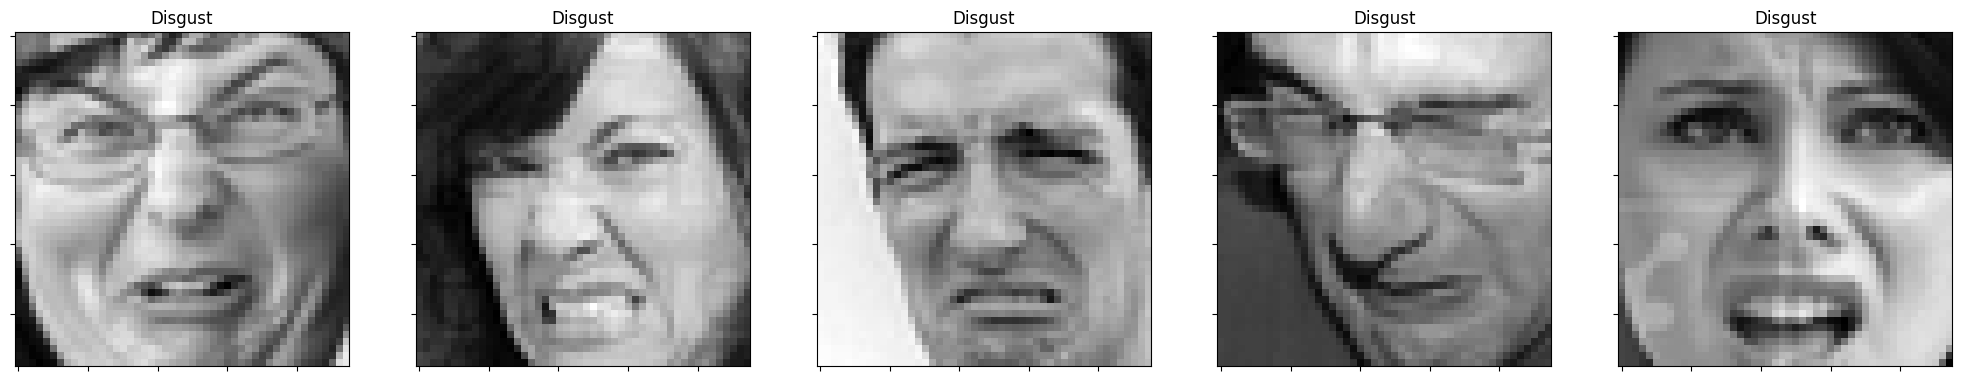

In [14]:
plot_examples(label=1)

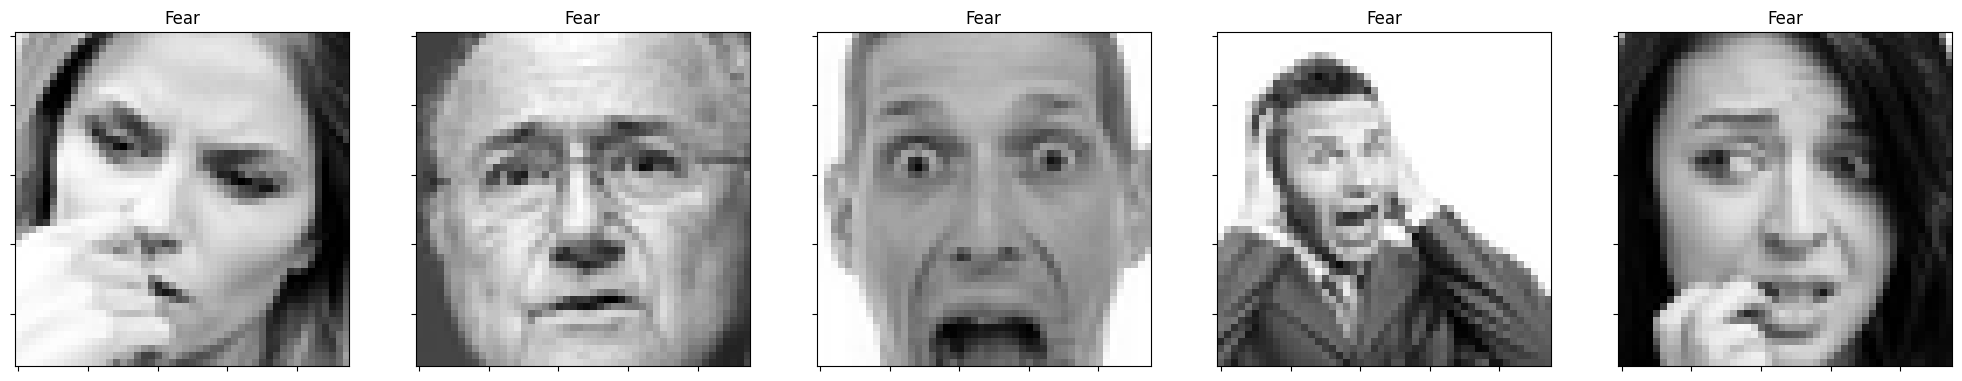

In [15]:
plot_examples(label=2)

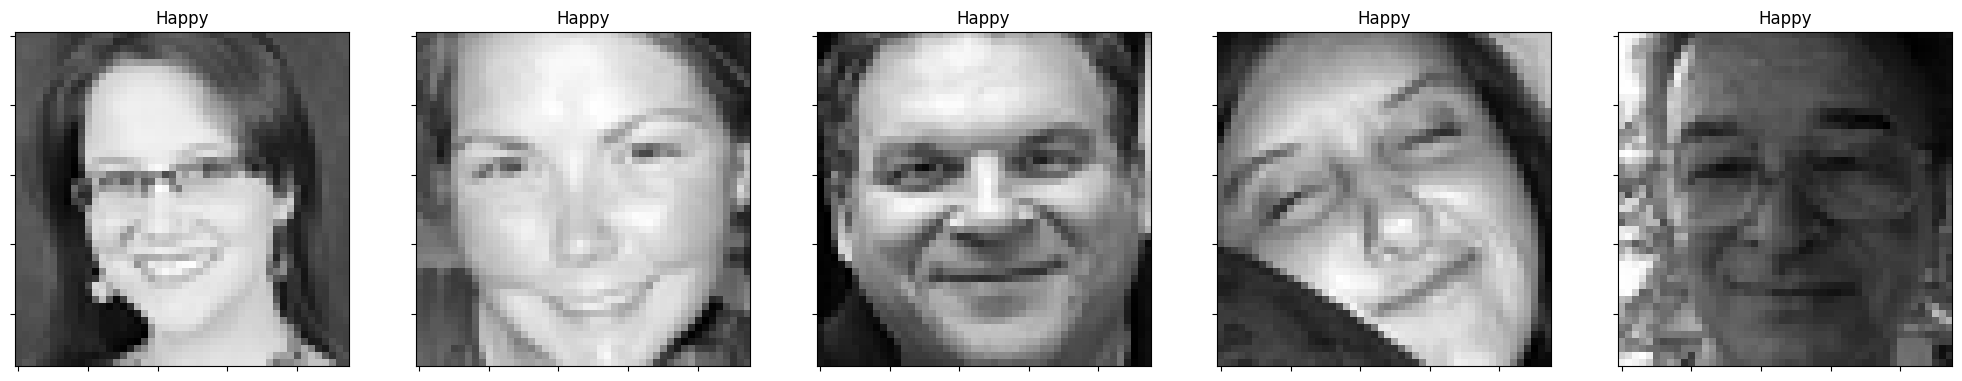

In [16]:
plot_examples(label=3)

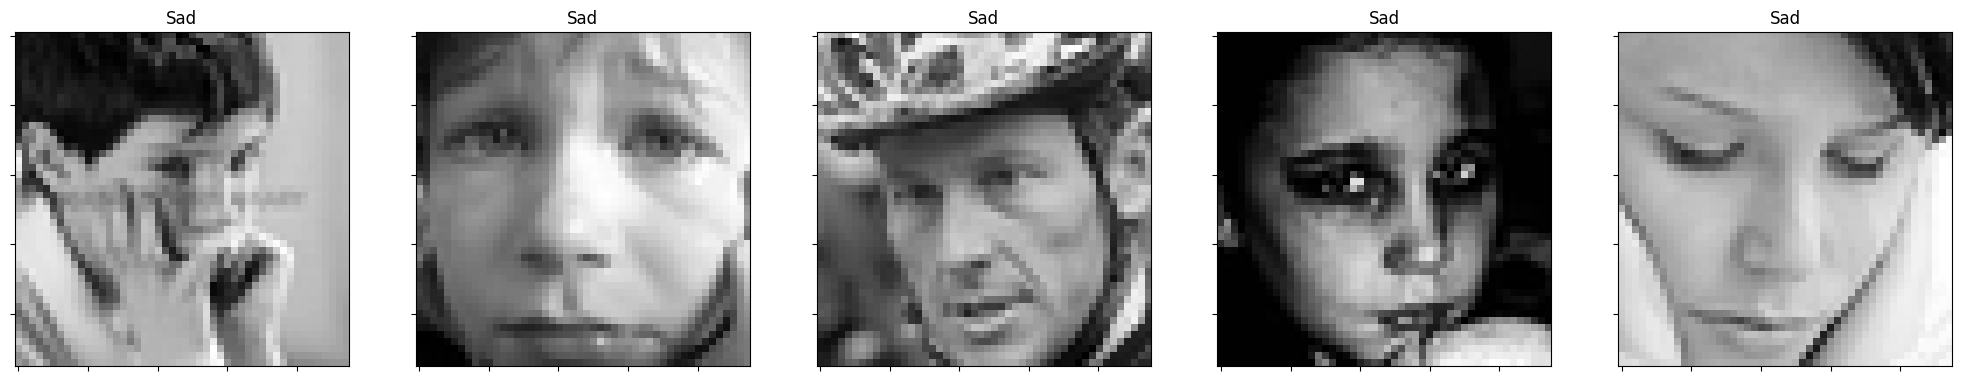

In [17]:
plot_examples(label=4)

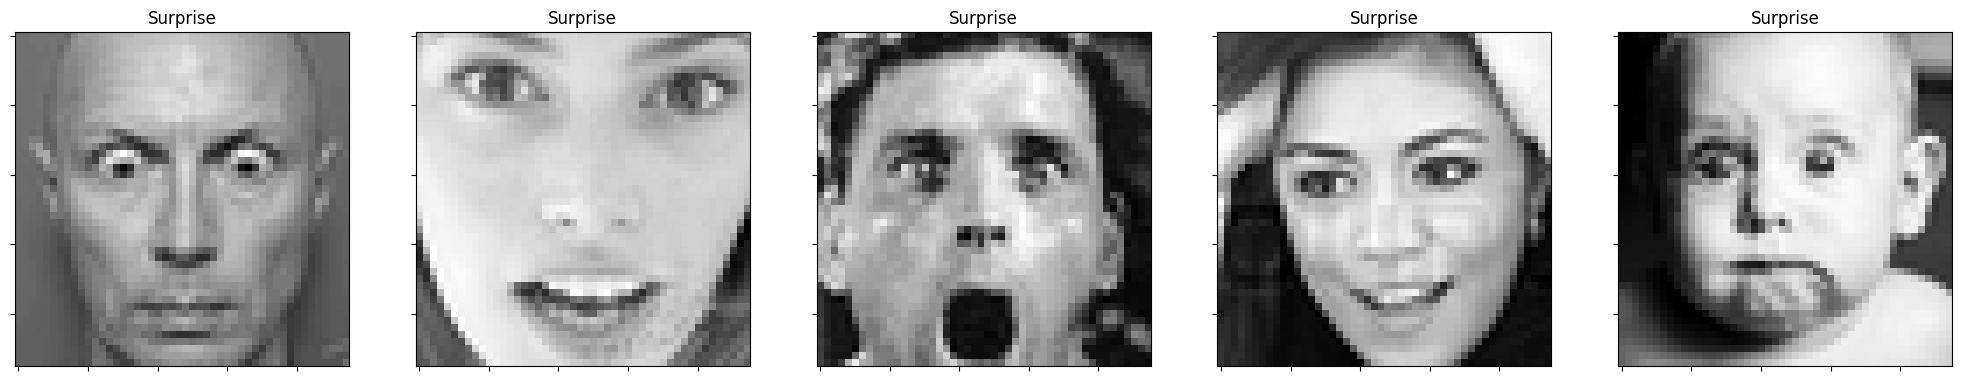

In [18]:
plot_examples(label=5)

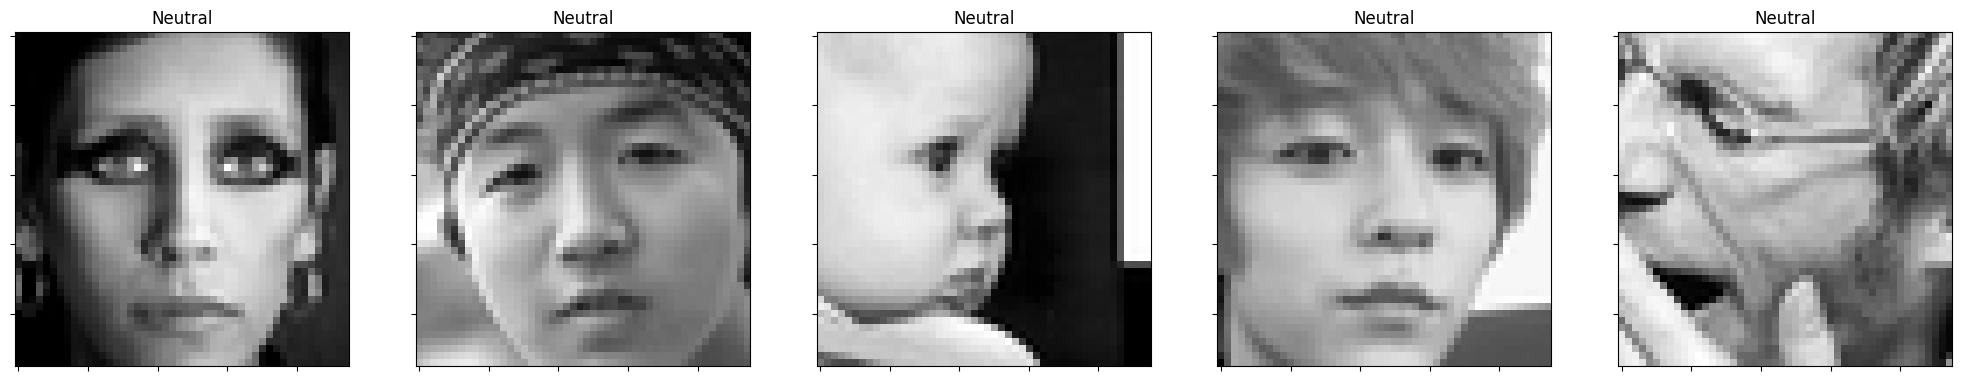

In [19]:
plot_examples(label=6)

train labels and validation labels

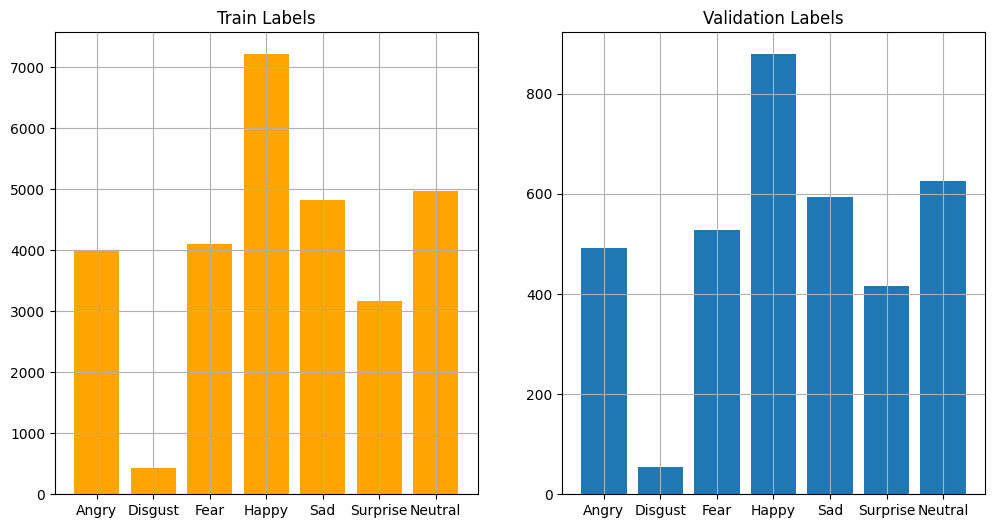

In [20]:
plot_compare_distributions(train_labels, val_labels, title1='Train Labels', title2='Validation Labels')

weight

In [21]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

Model training
* convolution layers
* pooldown layers
* dropout layers
* batch normalization layers
* dense layers

In [22]:
model = models.Sequential()

model.add(Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2),padding="same"))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        128       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 128)       0

compiling model

In [24]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

training model

In [25]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('model'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.3279
Epoch 1: val_accuracy improved from -inf to 0.36974, saving model to Checkpoints\model.h5
449/449 [==============================] - 2131s 5s/step - loss: 0.2758 - accuracy: 0.3279 - val_loss: 1.6503 - val_accuracy: 0.3697
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.4372
Epoch 2: val_accuracy improved from 0.36974 to 0.47144, saving model to Checkpoints\model.h5
449/449 [==============================] - 2136s 5s/step - loss: 0.2255 - accuracy: 0.4372 - val_loss: 1.3900 - val_accuracy: 0.4714
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.5112
Epoch 3: val_accuracy improved from 0.47144 to 0.49289, saving model to Checkpoints\model.h5
449/449 [==============================] - 2131s 5s/step - loss: 0.1980 - accuracy: 0.5112 - val_loss: 1.3420 - val_accuracy: 0.4929
Epoch 4/50
449/449 [=================

accuracy

In [26]:
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 547s 609ms/step - loss: 0.0070 - accuracy: 0.9974
Train Accuracy: 99.73527193069458


113/113 [==============================] - 69s 608ms/step - loss: 2.7218 - accuracy: 0.5651
Test Accuracy: 56.50599002838135


113/113 [==============================] - 68s 603ms/step - loss: 2.6771 - accuracy: 0.5704
Validation Accuracy: 57.03538656234741


prediction

In [27]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 67s 586ms/step


plots

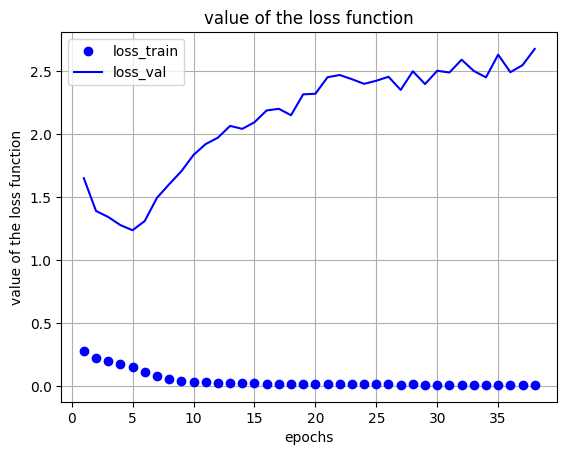

In [28]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

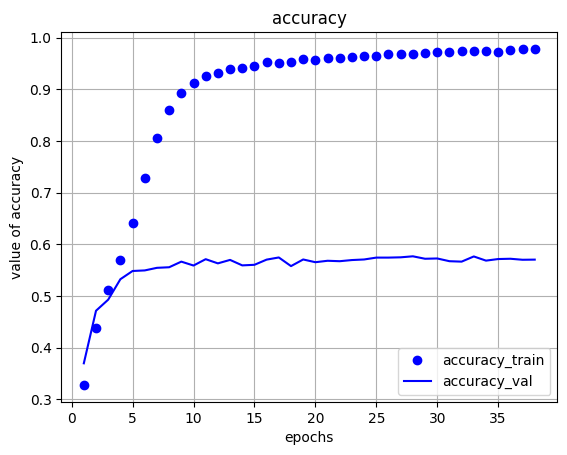

In [29]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

analyzing results

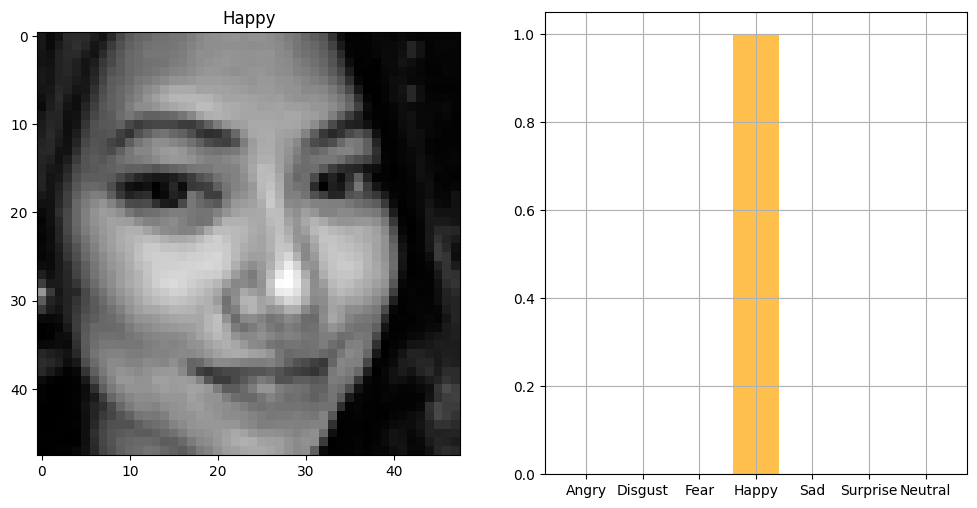

In [30]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 19)

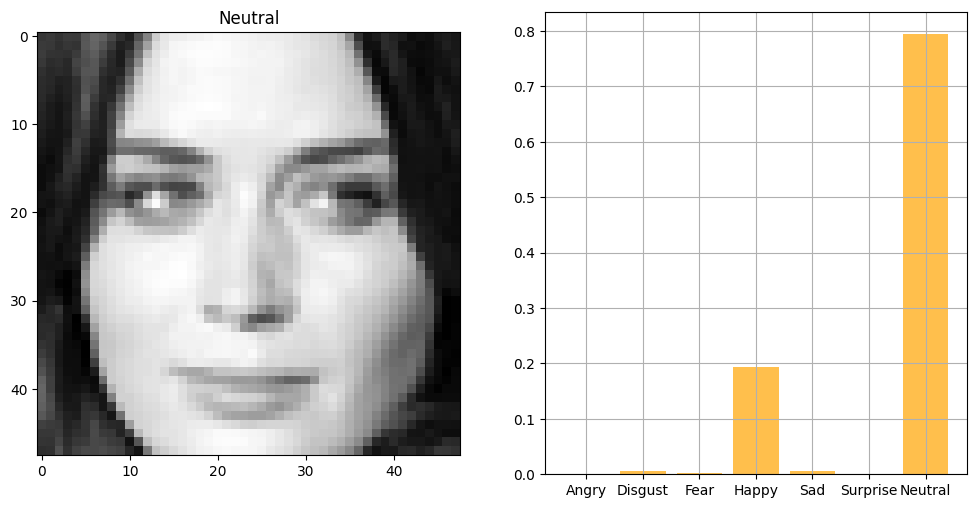

In [31]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 119)

predict comparision plot

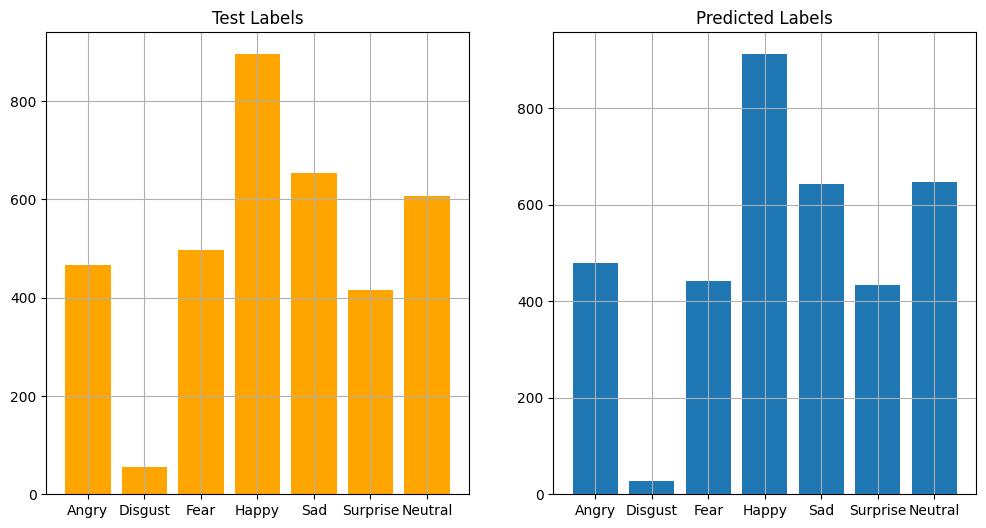

In [32]:
plot_compare_distributions(test_labels, pred_test_labels, title1='Test Labels', title2='Predicted Labels')

analys of incorrect prediction

confusion matrix

In [33]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

C:\Users\hzida\AppData\Local\Temp\ipykernel_13976\94775150.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


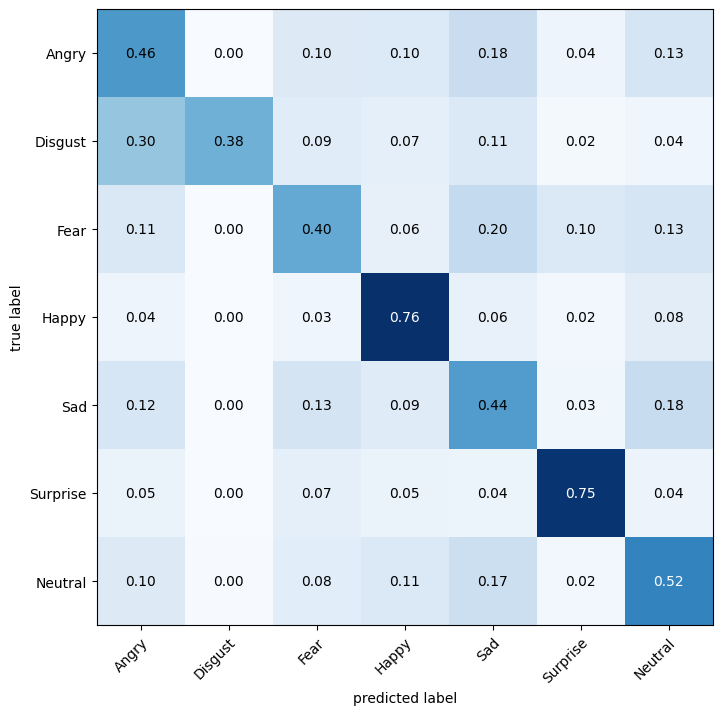

In [34]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()